In [1]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
import io
import pickle
import json

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T
import torch.nn.functional as F

from uNetModel import *
from encoder import *
from Unet_pretrained import *

In [2]:
# For this cell used same code from PyTorch notebook in assignment 2 of Stanford's CS231n Spring 2018 offering
preprocessData = False # To preprocess data set this to True
USE_GPU = True
dtype = torch.float32
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    dtype = torch.float32

# Constant to control how frequently we print train loss
print_every = 1

print('using device:', device)

using device: cuda


In [3]:
# For this cell, code belongs to [1]. Minor changes made to accomodate to our use 
# (Using PyTorch instead of Keras/tensorflow)
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
PATH = './stage1_train/'
epsilon = 1e-12 #For numerical stability

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 1
random.seed = seed
np.random.seed = seed

In [4]:
# Opening up json file that contains preprocessed images
with open('processedData.json') as f:
    data = json.load(f)

X_train = np.array(data['X_train'])
Y_train = np.array(data['Y_train'])
X_val = np.array(data['X_val'])
Y_val = np.array(data['Y_val'])
X_test = np.array(data['X_test'])
Y_test = np.array(data['Y_test'])

print('Shape of X_train = ', X_train.shape)
print('Shape of Y_train = ', Y_train.shape)
print('Shape of X_val = ', X_val.shape)
print('Shape of Y_val = ', Y_val.shape)
print('Shape of X_test = ', X_test.shape)
print('Shape of Y_test = ', Y_test.shape)

Shape of X_train =  (402, 3, 128, 128)
Shape of Y_train =  (402, 1, 128, 128)
Shape of X_val =  (134, 3, 128, 128)
Shape of Y_val =  (134, 1, 128, 128)
Shape of X_test =  (134, 3, 128, 128)
Shape of Y_test =  (134, 1, 128, 128)


In [5]:
def showVisualComparisons(y, pred):
    y_reshaped = np.transpose(y, (1,2,0))
    pred_reshaped = np.transpose(pred, (1,2,0))
    imshow(np.squeeze(np.uint8(y_reshaped)))
    plt.show()
    imshow(np.squeeze(np.uint8(pred_reshaped)))
    plt.show()

In [6]:
def calculatePerformance(X_perf, Y_perf, model, mini_batch_size =  64, visual = False):
    D = 1
    for i in range(len(Y_perf.shape)):
        D *= Y_perf.shape[i]
    model.eval() #set model to evaluation mode
    numCorrect = 0
    num_batches = int(X_perf.shape[0]/mini_batch_size)
    num_remaining = X_perf.shape[0] - num_batches *mini_batch_size
    with torch.no_grad():
        for i in range(num_batches):
            x = torch.from_numpy(X_perf[i*mini_batch_size:(i+1)*mini_batch_size, :, :, :])
            y = torch.from_numpy(Y_perf[i*mini_batch_size:(i+1)*mini_batch_size, :, :, :]).type(torch.cuda.FloatTensor)
            x = x.to(device = device, dtype = dtype)
            preds = model(x)
            preds = (preds > 0.5).type(preds.type())
            numCorrect += (preds==y).sum()
        x = torch.from_numpy(X_perf[num_batches*mini_batch_size:, :, :, :])
        y = torch.from_numpy(Y_perf[num_batches*mini_batch_size:, :, :, :]).type(torch.cuda.FloatTensor)
        x = x.to(device = device, dtype = dtype)
        preds = model(x)
        preds = (preds > 0.5).type(preds.type())
        if visual:
            ix = np.random.randint((num_batches*mini_batch_size), X_perf.shape[0])
            showVisualComparisons(Y_perf[ix, :, :, :], preds[(ix - (num_batches*mini_batch_size)), :, :, :].cpu().numpy())
        numCorrect += (preds==y).sum()
    return float(numCorrect)/float(D)

In [7]:
def trainModel(model, x_train, y_train, optimizer, epochs = 1, mini_batch_size = 64, noVal = False):
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    T = 0
    num_batches = int(len(x_train)/mini_batch_size)
    num_remaining = len(x_train) - num_batches *mini_batch_size
    loss_history = []
    for e in range(epochs):
        for t in range(num_batches):
            rand_indices = np.random.choice(len(x_train), mini_batch_size)
            x = torch.from_numpy(x_train[rand_indices, :, :, :])
            y = torch.from_numpy(y_train[rand_indices, :, :, :])
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=dtype)

            preds = model(x)
            loss = F.binary_cross_entropy(preds, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if T % print_every == 0:
                currLoss = loss.item()
                loss_history.append(currLoss)
                print('Epoch %d, Iteration %d, loss = %.4f' % (e, t, currLoss))
            if (num_remaining <= 0 and t == (num_batches -1)):
                percentCorrect = calculatePerformance(x_train, y_train, model)
                print('Train percent correct at epoch %d is %.4f' % (e, percentCorrect))
                if (noVal == False):
                    percentCorrect = calculatePerformance(X_val, Y_val, model)
                    print('Val percent correct at epoch %d is %.4f' % (e, percentCorrect))
            T +=1
        if num_remaining > 0:
            rand_indices = np.random.choice(len(x_train), num_remaining)
            x = torch.from_numpy(x_train[rand_indices, :, :, :])
            y = torch.from_numpy(y_train[rand_indices, :, :, :])
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=dtype)

            preds = model(x)
            loss = F.binary_cross_entropy(preds, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()
            if T % print_every == 0:
                currLoss = loss.item()
                loss_history.append(currLoss)
                print('Epoch %d, Iteration %d, loss = %.4f' % (e, num_batches, currLoss))
            percentCorrect = calculatePerformance(x_train, y_train, model)
            print('Train percent correct at epoch %d is %.4f' % (e, percentCorrect))
            if (noVal == False):
                percentCorrect = calculatePerformance(X_val, Y_val, model)
                print('Val percent correct at epoch %d is %.4f' % (e, percentCorrect))
            T +=1
    return calculatePerformance(x_train, y_train, model),loss_history

In [9]:
x_train = X_train[:50,:,:,:]
y_train = Y_train[:50, :,:,:]
print_every = 1
bestPerf = -1
bestLossHistory = None
lossHistories = {}
print_every = 1
bestModel = None
bestLoss = 10000
lrUsed = 0
lrs = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
for lr in lrs:
    model = UNet_pretrained()
    optimizer = optim.Adam(model.parameters(), lr = lr)
    modelPerf, lossHistory = trainModel(model, x_train, y_train, optimizer, epochs = 25, noVal = True)
    lossHistories[str(lr)] = lossHistory
    if lossHistory[len(lossHistory)-1] < bestLoss:
        bestLoss = lossHistory[len(lossHistory)-1]
        bestPerf = modelPerf
        bestLossHistory = lossHistory
        bestModel = model
        lrUsed = lr

Epoch 0, Iteration 0, loss = 4.8156
Train percent correct at epoch 0 is 0.7512
Epoch 1, Iteration 0, loss = 3.8363
Train percent correct at epoch 1 is 0.7775
Epoch 2, Iteration 0, loss = 1.9398
Train percent correct at epoch 2 is 0.6853
Epoch 3, Iteration 0, loss = 1.0318
Train percent correct at epoch 3 is 0.6570
Epoch 4, Iteration 0, loss = 1.5976
Train percent correct at epoch 4 is 0.8356
Epoch 5, Iteration 0, loss = 1.3172
Train percent correct at epoch 5 is 0.8473
Epoch 6, Iteration 0, loss = 0.8573
Train percent correct at epoch 6 is 0.8350
Epoch 7, Iteration 0, loss = 0.6388
Train percent correct at epoch 7 is 0.7969
Epoch 8, Iteration 0, loss = 0.4311
Train percent correct at epoch 8 is 0.8098
Epoch 9, Iteration 0, loss = 0.3901
Train percent correct at epoch 9 is 0.8087
Epoch 10, Iteration 0, loss = 0.3998
Train percent correct at epoch 10 is 0.7911
Epoch 11, Iteration 0, loss = 0.3461
Train percent correct at epoch 11 is 0.7956
Epoch 12, Iteration 0, loss = 0.2987
Train perce

Epoch 3, Iteration 0, loss = 12.5327
Train percent correct at epoch 3 is 0.4475
Epoch 4, Iteration 0, loss = 12.0193
Train percent correct at epoch 4 is 0.4478
Epoch 5, Iteration 0, loss = 12.6693
Train percent correct at epoch 5 is 0.4480
Epoch 6, Iteration 0, loss = 11.9714
Train percent correct at epoch 6 is 0.4482
Epoch 7, Iteration 0, loss = 12.4520
Train percent correct at epoch 7 is 0.4484
Epoch 8, Iteration 0, loss = 12.5856
Train percent correct at epoch 8 is 0.4487
Epoch 9, Iteration 0, loss = 12.5979
Train percent correct at epoch 9 is 0.4489
Epoch 10, Iteration 0, loss = 12.3752
Train percent correct at epoch 10 is 0.4492
Epoch 11, Iteration 0, loss = 12.2388
Train percent correct at epoch 11 is 0.4494
Epoch 12, Iteration 0, loss = 12.3398
Train percent correct at epoch 12 is 0.4496
Epoch 13, Iteration 0, loss = 12.6440
Train percent correct at epoch 13 is 0.4498
Epoch 14, Iteration 0, loss = 12.1561
Train percent correct at epoch 14 is 0.4501
Epoch 15, Iteration 0, loss = 

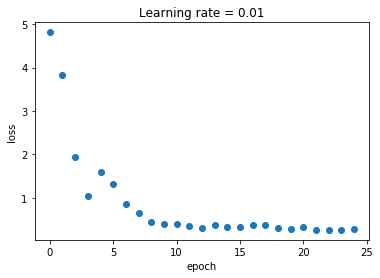

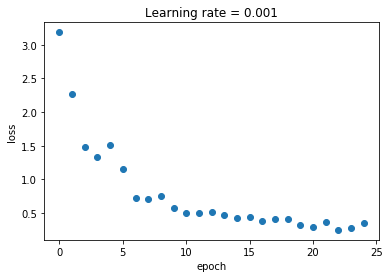

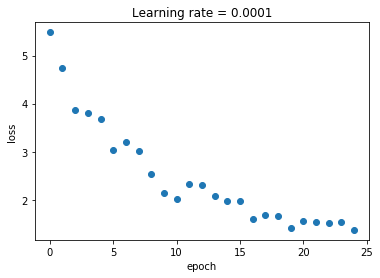

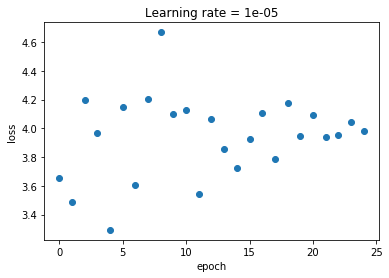

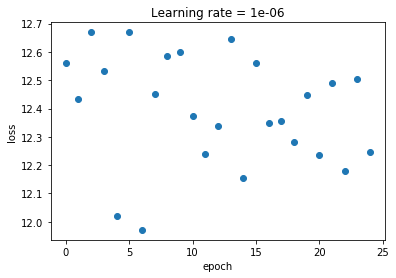

Lowest loss =  0.2825795114040375
Best lr =  0.01


In [11]:
# Let us take a look at the loss history to verify training
for lr, lossHist in lossHistories.items():
    plt.plot((np.arange(len(lossHist))),lossHist, 'o')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Learning rate = '+ lr)
    plt.show()
print('Lowest loss = ', str(bestLossHistory[len(bestLossHistory)-1]))
print('Best lr = ', str(lrUsed))

### Insight:
Looks like best training occurs at about 1e-2 so will explore randomly about this point.

In [24]:
x_train = X_train[:50,:,:,:]
y_train = Y_train[:50, :,:,:]
print_every = 1
bestPerf = -1
bestLossHistory = None
lossHistories = {}
print_every = 5
bestModel = None
bestLoss = 10000
lrUsed = 0
lrs = [0.014818826902875004, 0.002895034748289599,0.0056664758629998094]
for i in range(3):
     lrs.append(.05*np.random.random())
for lr in lrs:
    model = UNet_pretrained()
    optimizer = optim.Adam(model.parameters(), lr = lr)
    modelPerf, lossHistory = trainModel(model, x_train, y_train, optimizer, epochs = 40, noVal = True)
    lossHistories[str(lr)] = lossHistory
    if lossHistory[len(lossHistory)-1] < bestLoss:
        bestLoss = lossHistory[len(lossHistory)-1]
        bestPerf = modelPerf
        bestLossHistory = lossHistory
        bestModel = model
        lrUsed = lr

Epoch 0, Iteration 0, loss = 4.0066
Train percent correct at epoch 0 is 0.7694
Train percent correct at epoch 1 is 0.8328
Train percent correct at epoch 2 is 0.8338
Train percent correct at epoch 3 is 0.8330
Train percent correct at epoch 4 is 0.8347
Epoch 5, Iteration 0, loss = 4.1423
Train percent correct at epoch 5 is 0.7993
Train percent correct at epoch 6 is 0.8327
Train percent correct at epoch 7 is 0.8145
Train percent correct at epoch 8 is 0.7742
Train percent correct at epoch 9 is 0.8113
Epoch 10, Iteration 0, loss = 0.5877
Train percent correct at epoch 10 is 0.8284
Train percent correct at epoch 11 is 0.8160
Train percent correct at epoch 12 is 0.8296
Train percent correct at epoch 13 is 0.8351
Train percent correct at epoch 14 is 0.8364
Epoch 15, Iteration 0, loss = 0.5694
Train percent correct at epoch 15 is 0.8365
Train percent correct at epoch 16 is 0.8365
Train percent correct at epoch 17 is 0.8364
Train percent correct at epoch 18 is 0.8364
Train percent correct at epo

Train percent correct at epoch 1 is 0.8365
Train percent correct at epoch 2 is 0.8365
Train percent correct at epoch 3 is 0.8365
Train percent correct at epoch 4 is 0.8365
Epoch 5, Iteration 0, loss = 4.4862
Train percent correct at epoch 5 is 0.8365
Train percent correct at epoch 6 is 0.8365
Train percent correct at epoch 7 is 0.8365
Train percent correct at epoch 8 is 0.8365
Train percent correct at epoch 9 is 0.8365
Epoch 10, Iteration 0, loss = 5.0762
Train percent correct at epoch 10 is 0.8365
Train percent correct at epoch 11 is 0.8365
Train percent correct at epoch 12 is 0.8365
Train percent correct at epoch 13 is 0.8365
Train percent correct at epoch 14 is 0.8365
Epoch 15, Iteration 0, loss = 4.2978
Train percent correct at epoch 15 is 0.8365
Train percent correct at epoch 16 is 0.8365
Train percent correct at epoch 17 is 0.8365
Train percent correct at epoch 18 is 0.8365
Train percent correct at epoch 19 is 0.8365
Epoch 20, Iteration 0, loss = 3.2595
Train percent correct at e

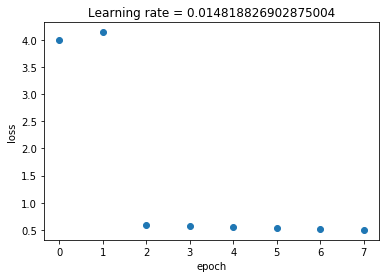

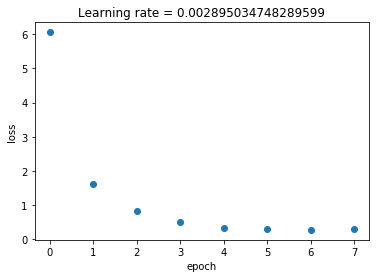

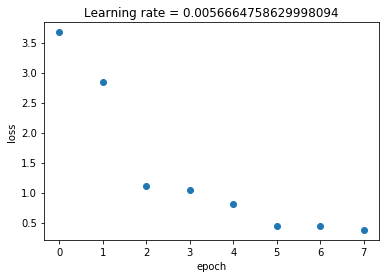

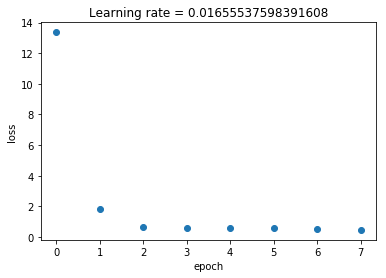

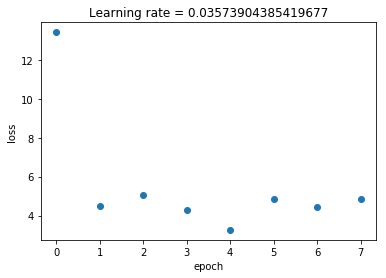

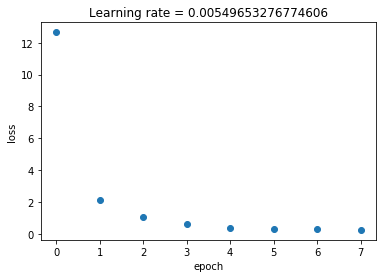

Lowest loss =  0.25016775727272034
Best lr =  0.00549653276774606


In [25]:
# Let us take a look at the loss history to verify training
for lr, lossHist in lossHistories.items():
    plt.plot((np.arange(len(lossHist))),lossHist, 'o')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Learning rate = '+ lr)
    plt.show()
print('Lowest loss = ', str(bestLossHistory[len(bestLossHistory)-1]))
print('Best lr = ', str(lrUsed))

Epoch 0, Iteration 0, loss = 4.2382
Epoch 0, Iteration 5, loss = 0.9684
Train percent correct at epoch 0 is 0.8366
Epoch 1, Iteration 3, loss = 0.5080
Train percent correct at epoch 1 is 0.8516
Epoch 2, Iteration 1, loss = 0.2933
Epoch 2, Iteration 6, loss = 0.2977
Train percent correct at epoch 2 is 0.8619
Epoch 3, Iteration 4, loss = 0.2950
Train percent correct at epoch 3 is 0.8658
Epoch 4, Iteration 2, loss = 0.2690
Train percent correct at epoch 4 is 0.8707
Epoch 5, Iteration 0, loss = 0.2428
Epoch 5, Iteration 5, loss = 0.1934
Train percent correct at epoch 5 is 0.8735
Epoch 6, Iteration 3, loss = 0.2195
Train percent correct at epoch 6 is 0.8857
Epoch 7, Iteration 1, loss = 0.1685
Epoch 7, Iteration 6, loss = 0.2104
Train percent correct at epoch 7 is 0.8989
Epoch 8, Iteration 4, loss = 0.1852
Train percent correct at epoch 8 is 0.9185
Epoch 9, Iteration 2, loss = 0.1901
Train percent correct at epoch 9 is 0.9317
Epoch 10, Iteration 0, loss = 0.1438
Epoch 10, Iteration 5, loss =

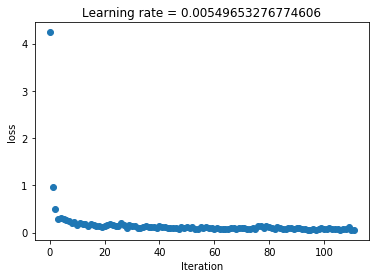

In [26]:
model = UNet_pretrained()
optimizer = optim.Adam(model.parameters(), lr = lrUsed)
modelPerf, lossHistory = trainModel(model, X_train, Y_train, optimizer, epochs = 80, noVal = True)
plt.plot((np.arange(len(lossHistory))),lossHistory, 'o')
plt.xlabel('Iteration')
plt.ylabel('loss')
plt.title('Learning rate = '+ str(lrUsed))
plt.show()

/home/shared/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


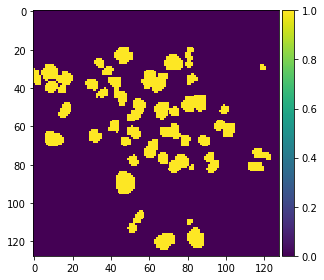

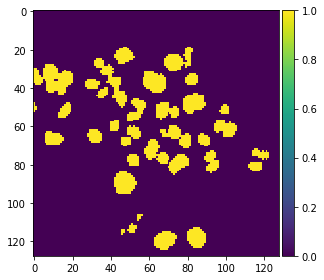

Percentage correct on train set =  0.9750932532163402
Percentage correct on val set =  0.9614699634153452


In [31]:
# Let us visualize how different our predicted masks are
print('Percentage correct on train set = ', calculatePerformance(X_train, Y_train, model, visual = True))
print('Percentage correct on val set = ', calculatePerformance(X_val, Y_val, model, visual = False))
torch.save(model, 'transferUNet')

In [32]:
# Let us visualize how different our predicted masks are
groupNormModel = torch.load('groupNormModel')
print('Percentage correct on train set = ', calculatePerformance(X_train, Y_train, groupNormModel, visual = False))
print('Percentage correct on val set = ', calculatePerformance(X_val, Y_val, groupNormModel, visual = False))

Percentage correct on train set =  0.9705418828708022
Percentage correct on val set =  0.9556196981401586


In [29]:
# Let us now compare to layer norm
layerNormModel = torch.load('layerNormModel')
print('Percentage correct on train set = ', calculatePerformance(X_train, Y_train, layerNormModel, visual = False))
print('Percentage correct on val set = ', calculatePerformance(X_val, Y_val, layerNormModel, visual = False))

Percentage correct on train set =  0.9827721439190765
Percentage correct on val set =  0.9523707147854478


In [30]:
# Let us now compare to baseline model
baselineModel = torch.load('baselineModel')
print('Percentage correct on train set = ', calculatePerformance(X_train, Y_train, baselineModel, visual = False))
print('Percentage correct on val set = ', calculatePerformance(X_val, Y_val, baselineModel, visual = False))

Percentage correct on train set =  0.9685116288673818
Percentage correct on val set =  0.9599504613164646


Epoch 0, Iteration 0, loss = 0.0831
Epoch 0, Iteration 5, loss = 0.1736
Train percent correct at epoch 0 is 0.8777
Epoch 1, Iteration 3, loss = 0.2299
Train percent correct at epoch 1 is 0.9077
Epoch 2, Iteration 1, loss = 0.1675
Epoch 2, Iteration 6, loss = 0.1467
Train percent correct at epoch 2 is 0.9277
Epoch 3, Iteration 4, loss = 0.1484
Train percent correct at epoch 3 is 0.9355
Epoch 4, Iteration 2, loss = 0.1268
Train percent correct at epoch 4 is 0.9452
Epoch 5, Iteration 0, loss = 0.1015
Epoch 5, Iteration 5, loss = 0.1130
Train percent correct at epoch 5 is 0.9639
Epoch 6, Iteration 3, loss = 0.0951
Train percent correct at epoch 6 is 0.9662
Epoch 7, Iteration 1, loss = 0.1410
Epoch 7, Iteration 6, loss = 0.0882
Train percent correct at epoch 7 is 0.9675
Epoch 8, Iteration 4, loss = 0.1193
Train percent correct at epoch 8 is 0.9692
Epoch 9, Iteration 2, loss = 0.1010
Train percent correct at epoch 9 is 0.9690
Epoch 10, Iteration 0, loss = 0.0795
Epoch 10, Iteration 5, loss =

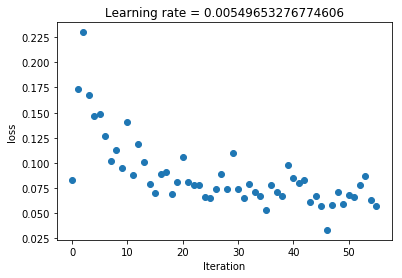

Epoch 0, Iteration 0, loss = 0.0733
Epoch 0, Iteration 5, loss = 0.0790
Train percent correct at epoch 0 is 0.9686
Epoch 1, Iteration 3, loss = 0.0947
Train percent correct at epoch 1 is 0.9701
Epoch 2, Iteration 1, loss = 0.0801
Epoch 2, Iteration 6, loss = 0.1068
Train percent correct at epoch 2 is 0.9702
Epoch 3, Iteration 4, loss = 0.0686
Train percent correct at epoch 3 is 0.9702
Epoch 4, Iteration 2, loss = 0.0870
Train percent correct at epoch 4 is 0.9714
Epoch 5, Iteration 0, loss = 0.0806
Epoch 5, Iteration 5, loss = 0.1013
Train percent correct at epoch 5 is 0.9704
Epoch 6, Iteration 3, loss = 0.0975
Train percent correct at epoch 6 is 0.9713
Epoch 7, Iteration 1, loss = 0.0968
Epoch 7, Iteration 6, loss = 0.1061
Train percent correct at epoch 7 is 0.9698
Epoch 8, Iteration 4, loss = 0.0910
Train percent correct at epoch 8 is 0.9717
Epoch 9, Iteration 2, loss = 0.0800
Train percent correct at epoch 9 is 0.9716
Epoch 10, Iteration 0, loss = 0.0882
Epoch 10, Iteration 5, loss =

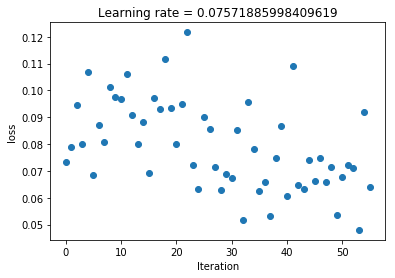

Epoch 0, Iteration 0, loss = 0.0516
Epoch 0, Iteration 5, loss = 0.0771
Train percent correct at epoch 0 is 0.9738
Epoch 1, Iteration 3, loss = 0.0755
Train percent correct at epoch 1 is 0.9777
Epoch 2, Iteration 1, loss = 0.0605
Epoch 2, Iteration 6, loss = 0.0766
Train percent correct at epoch 2 is 0.9800
Epoch 3, Iteration 4, loss = 0.0620
Train percent correct at epoch 3 is 0.9818
Epoch 4, Iteration 2, loss = 0.0543
Train percent correct at epoch 4 is 0.9815
Epoch 5, Iteration 0, loss = 0.0433
Epoch 5, Iteration 5, loss = 0.0500
Train percent correct at epoch 5 is 0.9825
Epoch 6, Iteration 3, loss = 0.0507
Train percent correct at epoch 6 is 0.9834
Epoch 7, Iteration 1, loss = 0.0480
Epoch 7, Iteration 6, loss = 0.0412
Train percent correct at epoch 7 is 0.9839
Epoch 8, Iteration 4, loss = 0.0437
Train percent correct at epoch 8 is 0.9846
Epoch 9, Iteration 2, loss = 0.0505
Train percent correct at epoch 9 is 0.9846
Epoch 10, Iteration 0, loss = 0.0475
Epoch 10, Iteration 5, loss =

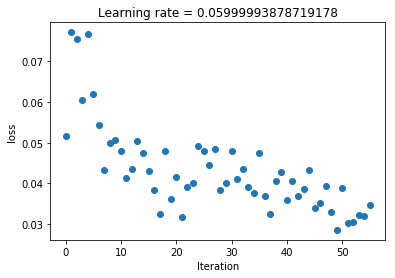

Epoch 0, Iteration 0, loss = 0.0594
Epoch 0, Iteration 5, loss = 0.2326
Train percent correct at epoch 0 is 0.9522
Epoch 1, Iteration 3, loss = 0.0818
Train percent correct at epoch 1 is 0.9621
Epoch 2, Iteration 1, loss = 0.1144
Epoch 2, Iteration 6, loss = 0.0830
Train percent correct at epoch 2 is 0.9621
Epoch 3, Iteration 4, loss = 0.1070
Train percent correct at epoch 3 is 0.9652
Epoch 4, Iteration 2, loss = 0.0937
Train percent correct at epoch 4 is 0.9669
Epoch 5, Iteration 0, loss = 0.1062
Epoch 5, Iteration 5, loss = 0.1449
Train percent correct at epoch 5 is 0.9689
Epoch 6, Iteration 3, loss = 0.0974
Train percent correct at epoch 6 is 0.9679
Epoch 7, Iteration 1, loss = 0.0708
Epoch 7, Iteration 6, loss = 0.0708
Train percent correct at epoch 7 is 0.9690
Epoch 8, Iteration 4, loss = 0.0956
Train percent correct at epoch 8 is 0.9697
Epoch 9, Iteration 2, loss = 0.0576
Train percent correct at epoch 9 is 0.9693
Epoch 10, Iteration 0, loss = 0.1089
Epoch 10, Iteration 5, loss =

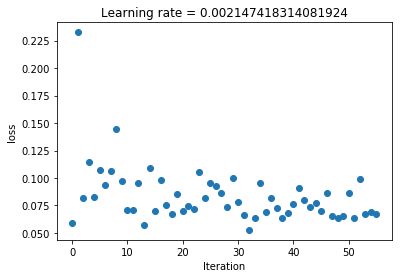

In [34]:
models = [model, groupNormModel, layerNormModel, baselineModel]
lrs = [lrUsed, 0.07571885998409619, .05999993878719178, 0.002147418314081924]
iToNames = ['bestTransferUNet','bestGroupNormUNet','bestLayerNormUNet', 'bestBaselineUNet']
for i in range(len(models)):
    currModel = models[i]
    optimizer = optim.Adam(currModel.parameters(), lr = lrs[i])
    modelPerf, lossHistory = trainModel(currModel, X_train, Y_train, optimizer, epochs = 40, noVal = True)
    plt.plot((np.arange(len(lossHistory))),lossHistory, 'o')
    plt.xlabel('Iteration')
    plt.ylabel('loss')
    plt.title('Learning rate = '+ str(lrs[i]))
    plt.show()
    torch.save(currModel, iToNames[i])

In [36]:
for modelName in iToNames:
    currModel = torch.load(modelName)
    print(modelName, ' percent correct on train set = ', calculatePerformance(X_train, Y_train, currModel, visual = False))
    print(modelName, ' percent correct on val set = ', calculatePerformance(X_val, Y_val, currModel, visual = False))
    print(modelName, ' percent correct on test set = ', calculatePerformance(X_test, Y_test, currModel, visual = False))

bestTransferUNet  percent correct on train set =  0.9741531296155939
bestTransferUNet  percent correct on val set =  0.9652245364972015
bestTransferUNet  percent correct on test set =  0.9735991065181903
bestGroupNormUNet  percent correct on train set =  0.9719236762962531
bestGroupNormUNet  percent correct on val set =  0.9596398197003265
bestGroupNormUNet  percent correct on test set =  0.9726457738164646
bestLayerNormUNet  percent correct on train set =  0.9882000216204135
bestLayerNormUNet  percent correct on val set =  0.9510866990729944
bestLayerNormUNet  percent correct on test set =  0.96240234375
bestBaselineUNet  percent correct on train set =  0.9731689756782493
bestBaselineUNet  percent correct on val set =  0.9645909551364272
bestBaselineUNet  percent correct on test set =  0.9715421306553171


# References
[1] Amdal-Saevik, K. (2018). Keras U-Net starter - LB 0.277. 
https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277?scriptVersionId=2164855/code

[2] Ho, D. J., Fu, C., Salama, P., Dunn, K. W., and Delp, E. J. (2017, July). Nuclei Segmentation of Fluorescence Microscopy Images Using Three Dimensional Convolutional Neural Networks. In Computer Vision and Pattern Recognition Workshops (CVPRW), 2017 IEEE Conference on (pp. 834-842). IEEE.

[3] Kakade, A., and Dumbali, J. (2018, February). Identification of nerve in ultrasound images using U-net architecture. In 2018 International Conference on Communication information and Computing Technology (ICCICT) (pp. 1-6). IEEE.

[4] Li, X., Chen, H., Qi, X., Dou, Q., Fu, C. W., and Heng, P. A. (2017). H-DenseUNet: Hybrid densely connected UNet for liver and liver tumor segmentation from CT volumes. arXiv preprint arXiv:1709.07330.

[5] Ronneberger, O., Fischer, P., and Brox, T. 
(2015, October). U-net: Convolutional networks for biomedical image segmentation. In International Conference on Medical image computing and computer-assisted intervention (pp. 234-241). Springer, Cham.

[6] Pearce, C. Convolutional (2017). Neural Networks and the Analysis of Cancer Imagery.

[7] Imagenet. https://patrykchrabaszcz.github.io/Imagenet32/